# Stock Predictor

## 0. Introduction:

The purpose of this project is to evaluate stock prices and employ various machine learning methods to try and predict their behavior in the future. The motivation for this project is due to personal interest (investing), and the fact that stocks provide a wealth of historical data to include in a machine learning problem. Also, I am interested in determining the effect of the COVID-19 pandemic on stocks in general. 

This project will try and answer these COVID-19 related questions:

- Which stocks prices have risen (or fallen) the most during COVID-19?
- How have stock fundamentals/financials changed before vs. during COVID-19?
- Which stocks rise and fall together (clustering) before vs. during COVID-19?
- Which stocks are correlated to COVID-19 virus/lockdown sentiment?

Also, the project will try and answer these general questions:

- Can we predict future stock prices (supervised regression) using forecasting techniques?
- Can we predict future stock prices (supervised regression) using sentiment data or company financial data?
- Can we predict if stock prices will rise or fall (supervised classification) using sentiment data or company financial data?
- Practice: Set up a ETL pipeline and display stock pick recommendation on dashboard

<u>TABLE OF CONTENTS:</u> 
0. Introduction
1. Data Input
2. Data Processing/Cleaning
3. Data Visualization/EDA
    * 3.1. Stock Sector Prices Before vs. During COVID-19  
    * 3.2. Stock Sector Fundamentals Before vs. During COVID-19     
    * 3.3. Stock Clustering Before vs. During COVID-19    
    * 3.4. Stock Correlation to Negative Virus Sentiment  
4. Data Prediction
    * 4.1. Linear Regression of Stock Prices By Sector
    * 4.2. 
    * 4.3. 
    * 4.4. 
    * 4.5. 
5. Conclusion

## 1. Data Input:

In [33]:
# load required libraries
import os
import re
from glob import glob 
import string
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.collections as collections 
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.dates as mdates
from datetime import datetime, time
# import packages
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
from datetime import date, datetime
import time
# import libraries
from datetime import timedelta, date, datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk


### 1.1 Stock Tickers:

In [34]:
def get_tickers(url):
    
    # set driver options and request options
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--headless')
    options.add_argument('--incognito')
    driver = webdriver.Chrome(ChromeDriverManager().install())
    headers = {"User-Agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.39 Safari/537.36', 
                "Accept": 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9'}
    url = 'https://old.nasdaq.com/screening/companies-by-name.aspx?&render=download'
    driver.delete_all_cookies()
    driver.get(url)
    time.sleep(2)

    # get current working directory
    current_folder = os.getcwd()

    # set os path for downloads folder
    data_folder = os.path.join("/", "Users", "mcgaritym", "Downloads")

    # get csv(s) from data_folder directory
    file = glob(os.path.join(data_folder, '*companylist*.csv'))
    for f in file:
        df_tickers = pd.read_csv(f)

    df_tickers = df_tickers[['Symbol', 'Name', 'MarketCap', 'Sector', 'industry']]
    df_tickers = df_tickers.dropna(subset=['MarketCap'])
    df_tickers['MarketCap'] = df_tickers['MarketCap'].astype(str)
    df_tickers['MarketCap'] = df_tickers['MarketCap'].apply(lambda x: x.replace('$', ''))
    df_tickers['MarketCap'] = df_tickers['MarketCap'].apply(lambda x: x.replace('B', '0000000'))
    df_tickers['MarketCap'] = df_tickers['MarketCap'].apply(lambda x: x.replace('M', '0000'))
    df_tickers['MarketCap'] = df_tickers['MarketCap'].apply(lambda x: x.replace('.', ''))
    df_tickers['MarketCap'] = df_tickers['MarketCap'].astype(int)
    df_tickers['MarketCap'] = df_tickers['MarketCap'].sort_values(ascending=False)    
    
    return df_tickers


url = 'https://old.nasdaq.com/screening/companies-by-name.aspx?&render=download'
df_tickers = get_tickers(url)

# print sample data
print(df_tickers.sort_values(by='MarketCap', ascending=False))

[WDM] - Current google-chrome version is 88.0.4324
[WDM] - Get LATEST driver version for 88.0.4324
[WDM] - Driver [/Users/mcgaritym/.wdm/drivers/chromedriver/mac64/88.0.4324.96/chromedriver] found in cache


 
     Symbol                                      Name      MarketCap  \
511    AAPL                                Apple Inc.  2289050000000   
4562   MSFT                     Microsoft Corporation  1696120000000   
305    GOOG                             Alphabet Inc.  1276350000000   
306   GOOGL                             Alphabet Inc.  1271730000000   
6662   TSLA                              Tesla, Inc.    806140000000   
...     ...                                       ...            ...   
1525   CLEU  China Liberal Education Holdings Limited         240000   
5262   PFIN                    P & F Industries, Inc.         190000   
863    DFVS                              Barclays PLC         190000   
4968   NVFY                       Nova Lifestyle, Inc         160000   
2380   ENSV                      ENSERVCO Corporation         110000   

                 Sector                                         industry  
511          Technology                           Computer

In [35]:
# print number of companies per sector
print(df_tickers['Sector'].value_counts())

Health Care              1000
Finance                   938
Consumer Services         756
Technology                655
Capital Goods             381
Basic Industries          306
Energy                    229
Consumer Non-Durables     212
Public Utilities          186
Miscellaneous             150
Consumer Durables         140
Transportation            102
Name: Sector, dtype: int64


In [36]:
# print number of companies per sector
print(df_tickers['industry'].value_counts())

Major Pharmaceuticals                              531
Major Banks                                        308
Business Services                                  289
Real Estate Investment Trusts                      205
Computer Software: Prepackaged Software            178
                                                  ... 
Precision Instruments                                1
Electronics Distribution                             1
Tools/Hardware                                       1
General Bldg Contractors - Nonresidential Bldgs      1
Tobacco                                              1
Name: industry, Length: 135, dtype: int64


In [37]:
def top_tickers(df, sector):
    
    ticker_list = []
    
    for sec in sector:
                
        # filter by sector and sort by market cap
        df_tick = df[df['Sector'] == sec].sort_values(by='MarketCap', ascending=False)
        df_tick = list(df_tick.iloc[:10]['Symbol'])   
        
        for tick in df_tick:
            
            ticker_list.append(tick)
                         
    return ticker_list  

# print sample data
top_tickers(df_tickers, sector = ['Technology', 'Consumer Durables'])

# print number of companies per sector
print(list(df_tickers['Sector'].unique()))

['Capital Goods', 'Health Care', 'Consumer Services', 'Finance', 'Technology', 'Consumer Non-Durables', 'Miscellaneous', 'Consumer Durables', nan, 'Energy', 'Public Utilities', 'Basic Industries', 'Transportation']


In [38]:
def top_tickers_industry(df, industry):
    
    ticker_list = []
    
    for ind in industry:
                
        # filter by sector and sort by market cap
        df_tick = df[df['industry'] == ind].sort_values(by='MarketCap', ascending=False)
        df_tick = list(df_tick.iloc[:3]['Symbol'])   
        
        for tick in df_tick:
            
            ticker_list.append(tick)
                         
    return ticker_list 

# print sample data
ticker_list_ind = top_tickers_industry(df_tickers, industry = list(df_tickers['industry'].unique()))
ticker_list_ind

# print number of companies per sector
# print(list(df_tickers['industry'].unique()))

['ILMN',
 'A',
 'MTD',
 'WBA',
 'TDOC',
 'OSH',
 'SE',
 'TAL',
 'JCI',
 'SFE',
 'TURN',
 'LYL',
 'JNJ',
 'NVS',
 'MRK',
 'JD',
 'ORLY',
 'AZO',
 'MHK',
 'WSM',
 'TPX',
 'NYCB',
 'BHLB',
 'HFWA',
 'HSBC',
 'PBCT',
 'TFSL',
 'JPM',
 'BAC',
 'WFC',
 'GOOG',
 'GOOGL',
 'FB',
 'PM',
 'BTI',
 'MO',
 'MSFT',
 'ADBE',
 'CRM',
 'AXP',
 'SPGI',
 'MCO',
 'BABA',
 'V',
 'MA',
 'MMM',
 'SYK',
 'BDX',
 'AMGN',
 'GILD',
 'MRNA',
 'DIS',
 'DKNG',
 'WMG',
 'ABNB',
 'PAYX',
 'URI',
 'INFY',
 'FISV',
 'ADP',
 'ASML',
 'TMO',
 'DHR',
 'NWSA',
 'NYT',
 'TPCO',
 'SNE',
 'GE',
 'EMR',
 'CSCO',
 'ANET',
 'FFIV',
 'HON',
 'BA',
 'RTX',
 'ABB',
 'APH',
 'TER',
 'TJX',
 'ROST',
 'LB',
 'TOT',
 'PBR',
 'PTR',
 'NVDA',
 'INTC',
 'AVGO',
 'APPS',
 'DLB',
 'JYNT',
 'UNH',
 'CI',
 'ANTM',
 'AMT',
 'PLD',
 'EQIX',
 'CVNA',
 'CPRT',
 'KMX',
 'TRI',
 'RELX',
 'CMPR',
 'IDXX',
 'QDEL',
 'NEOG',
 'AYI',
 'PGTI',
 'PGTI',
 'HAS',
 'MAT',
 'YETI',
 'EXPD',
 'CHRW',
 'MIC',
 'GWW',
 'NCR',
 'MLHR',
 'APTV',
 'TT',
 'IEP',
 '

### 1.2 Stock Fundamentals (Prices, Volume, Splits, Revenue, Earnings):

In [42]:
# define function for generating stock history of each ticker and concatenate to master dataframe
def stock_preprocess(tickers):

    # create empty dataframe
    df_api = pd.DataFrame()
    
    # loop over each stock ticker
    for tick in tickers:
            
        # input various stock tickers 
        ticker = yf.Ticker(tick)
        
        # get historical market data
        stock_hist = ticker.history(period="1y", interval='1D', auto_adjust = True)
    
        # rename columns unique to eack ticker
        stock_hist = stock_hist[['Close', 'Volume']]
        
        # get quarterly earnings
        stock_earnings = ticker.quarterly_earnings
        
        # rename columns unique to each ticker, and format dates (assume the earning reporting dates are 1 month after quarter ends)
        stock_earnings = stock_earnings.reset_index()
        stock_earnings = stock_earnings.rename(columns = {'Quarter': 'Date'})
        stock_earnings = stock_earnings.replace(('4Q2019', '1Q2020', '2Q2020', '3Q2020'), ('2020-01-31', '2020-04-30', '2020-07-30', '2020-10-31')   )
        stock_earnings['Date'] = pd.to_datetime(stock_earnings['Date'])
        
        # concat dataframes
        stock_hist = stock_hist.merge(stock_earnings, on='Date', how='outer')
        
        # sort date values
        stock_hist = stock_hist.set_index('Date')
        stock_hist = stock_hist.sort_index(ascending=True)
        
        # fill in nan values and drop remaining nan values
        stock_hist = stock_hist.fillna(method = 'ffill')
        stock_hist = stock_hist.dropna()
        stock_hist = stock_hist.drop_duplicates()
        
        # rename columns with ticker name
        stock_hist = stock_hist.rename(columns=lambda x: tick.upper() + '_' + x)
        
        # append to empty dataframe
        df_api = pd.concat([df_api, stock_hist], axis=1, sort=False)
                        
    # print and specift dataframe is returned    
    return df_api

# print sample data call function with ticker_input
stock_preprocess(['AMZN', 'MSFT']).head()

,AMZN_Close,AMZN_Volume,AMZN_Revenue,AMZN_Earnings,MSFT_Close,MSFT_Volume,MSFT_Revenue,MSFT_Earnings
Date,,,,,,,,
2020-01-31,2008.719971,15567300.0,8.743600e+10,3.268000e+09,168.445557,36142700.0,3.690600e+10,1.164900e+10
2020-02-03,2004.199951,5899100.0,8.743600e+10,3.268000e+09,172.552048,30149100.0,3.690600e+10,1.164900e+10
2020-02-04,2049.669922,5289300.0,8.743600e+10,3.268000e+09,178.231873,36433300.0,3.690600e+10,1.164900e+10
2020-02-05,2039.869995,4376200.0,8.743600e+10,3.268000e+09,178.014191,39186300.0,3.690600e+10,1.164900e+10
2020-02-06,2050.229980,3183000.0,8.743600e+10,3.268000e+09,181.705093,27751400.0,3.690600e+10,1.164900e+10


### 1.3 Financial News Sentiment:

In [27]:
# FINANCIAL NEWS HEADLINES - retrieve data
def get_news():
    
    # get current parent directory and data folder path
    par_directory = os.path.dirname(os.getcwd())
    data_directory = os.path.join(par_directory, 'data/raw')

    # specify file names
    files_headlines = glob(os.path.join(data_directory, '*fin_news_headlines*.csv'))

    ## create empty dataframe, loop over files and concatenate data to dataframe. next, reset index and print tail
    df_news = pd.DataFrame()
    for f in files_headlines:
        data = pd.read_csv(f, parse_dates = ['date'])
        df_news = pd.concat([df_news, data], axis=0, sort='False')
    df_news = df_news.dropna()
    df_news = df_news.drop_duplicates()
    
    # reset index, sort values by date and print data sample
    df_news = df_news.reset_index(drop=True)
    df_news = df_news.sort_values(by='date', ascending=True)
    df_news = df_news.rename(columns = {'date': 'Date'})
    df_news['Date'] = pd.to_datetime(df_news['Date'])
    df_news = df_news.set_index('Date')
    
    return df_news

df_news = get_news()

# print sample data
df_news.head()

,headline,org
Date,,
2020-07-12 12:32:37,S&P 500 earnings set to plunge as the coronavi...,yahoofinance
2020-07-12 12:32:37,How to Invest in MLP Stocks,yahoofinance
2020-07-12 12:32:37,Trading set to triumph in US banks’ second-qua...,yahoofinance
2020-07-12 12:32:37,WeWork on track for profits and positive cash ...,yahoofinance
2020-07-12 12:32:37,"JPMorgan, BlackRock, Wells Fargo Among Financi...",yahoofinance


## 2. Data Processing/Cleaning:

In [28]:
def clean_news(df):
  
    # drop nan and duplicate values and filter for headline length more than 3 words
    df_news = df.dropna()
    df_news = df_news.drop_duplicates()
    df_news['headline_length'] = [len(x.split()) for x in df_news['headline']]
    df_news = df_news[df_news['headline_length'] > 3]
    

    # create sentiment column for news headlines
    sid = SentimentIntensityAnalyzer()
    df_news['sentiment'] = df_news['headline'].apply(sid.polarity_scores)
    df_news['sentiment'] = df_news['sentiment'].apply(lambda x: x['compound'])

    # resample daily and groupby organization
    company_sentiment = df_news.groupby('org')['sentiment'].resample('1 d').mean().unstack(level=0)
    company_sentiment = company_sentiment.rename(columns=lambda x: x + '_sentiment')

    # create overall sentiment column
    company_sentiment['overall_sentiment'] = company_sentiment.mean(axis=1)

    return company_sentiment

df_news = clean_news(df_news)

# print sample data
df_news.head()

org,bloomberg_sentiment,cnbc_sentiment,cnn_sentiment,cnnbusiness_sentiment,economist_sentiment,financialtimes_sentiment,forbes_sentiment,fortune_sentiment,foxbusiness_sentiment,googlenews_sentiment,ibtimes_sentiment,marketwatch_sentiment,morningstar_sentiment,motleyfool_sentiment,msnmoney_sentiment,seekingalpha_sentiment,thestreet_sentiment,wsj_sentiment,yahoofinance_sentiment,overall_sentiment
Date,,,,,,,,,,,,,,,,,,,,
2020-07-12,0.017152,0.041875,0.039259,0.019139,0.039587,-0.026454,0.038373,0.006634,0.063012,0.049029,0.012100,0.071553,0.113454,0.119425,0.083740,-0.058320,0.015396,0.079112,0.123815,0.044625
2020-07-13,-0.086797,0.001616,0.156203,-0.035982,NaN,0.033576,-0.065333,0.016558,-0.049071,0.075603,0.005120,0.026499,0.046334,0.142780,0.042242,0.136375,0.078739,0.024118,0.106491,0.036393
2020-07-14,NaN,0.020116,-0.017741,-0.025709,NaN,-0.044532,-0.055646,0.026998,0.003331,0.003767,-0.061897,-0.021709,0.042848,0.076813,-0.023245,0.078410,0.044478,-0.029538,0.103337,0.007064
2020-07-15,0.000874,0.103024,0.089648,-0.023556,NaN,-0.018404,-0.038711,-0.081143,0.013181,0.081592,0.087323,0.070718,0.133410,0.152580,0.009366,0.109207,0.075157,0.042662,0.094802,0.050096
2020-07-16,-0.033208,0.026437,-0.007182,-0.125307,-0.011429,-0.040083,0.055690,0.021719,0.003442,0.011241,-0.036018,-0.051507,0.126106,0.112117,0.037070,0.094013,0.018700,-0.059790,0.029518,0.009028


## 3. Data Visualization/EDA

### 3.1. Stocks Sector Prices Before vs. During COVID-19

In [29]:
def plot_prices(df_tickers, sector):
    
    # get top 10 tickers for sector, process, and filter columns for closing prices
    tickers = top_tickers(df_tickers, [sector])
    print(tickers)
    df = stock_preprocess(tickers)
    cols = df.columns[df.columns.str.contains(pat = 'Close')] 
    df = df[cols]
    
    # set seaborn style, plot options and plot closing prices
    sns.set()
    fig, ax = plt.subplots(figsize = (12,8), dpi=300)
    sns.lineplot(data=df, dashes=False)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    plt.xticks(rotation=45, fontsize=12) 
    ax.set_title('Closing Prices of Stocks: {}'.format(sector), fontweight ='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Closing Price ($ USD)')
    plt.show()
       

['JNJ', 'UNH', 'NVS', 'MRK', 'PFE', 'ABT', 'ABBV', 'LLY', 'NVO', 'MDT']


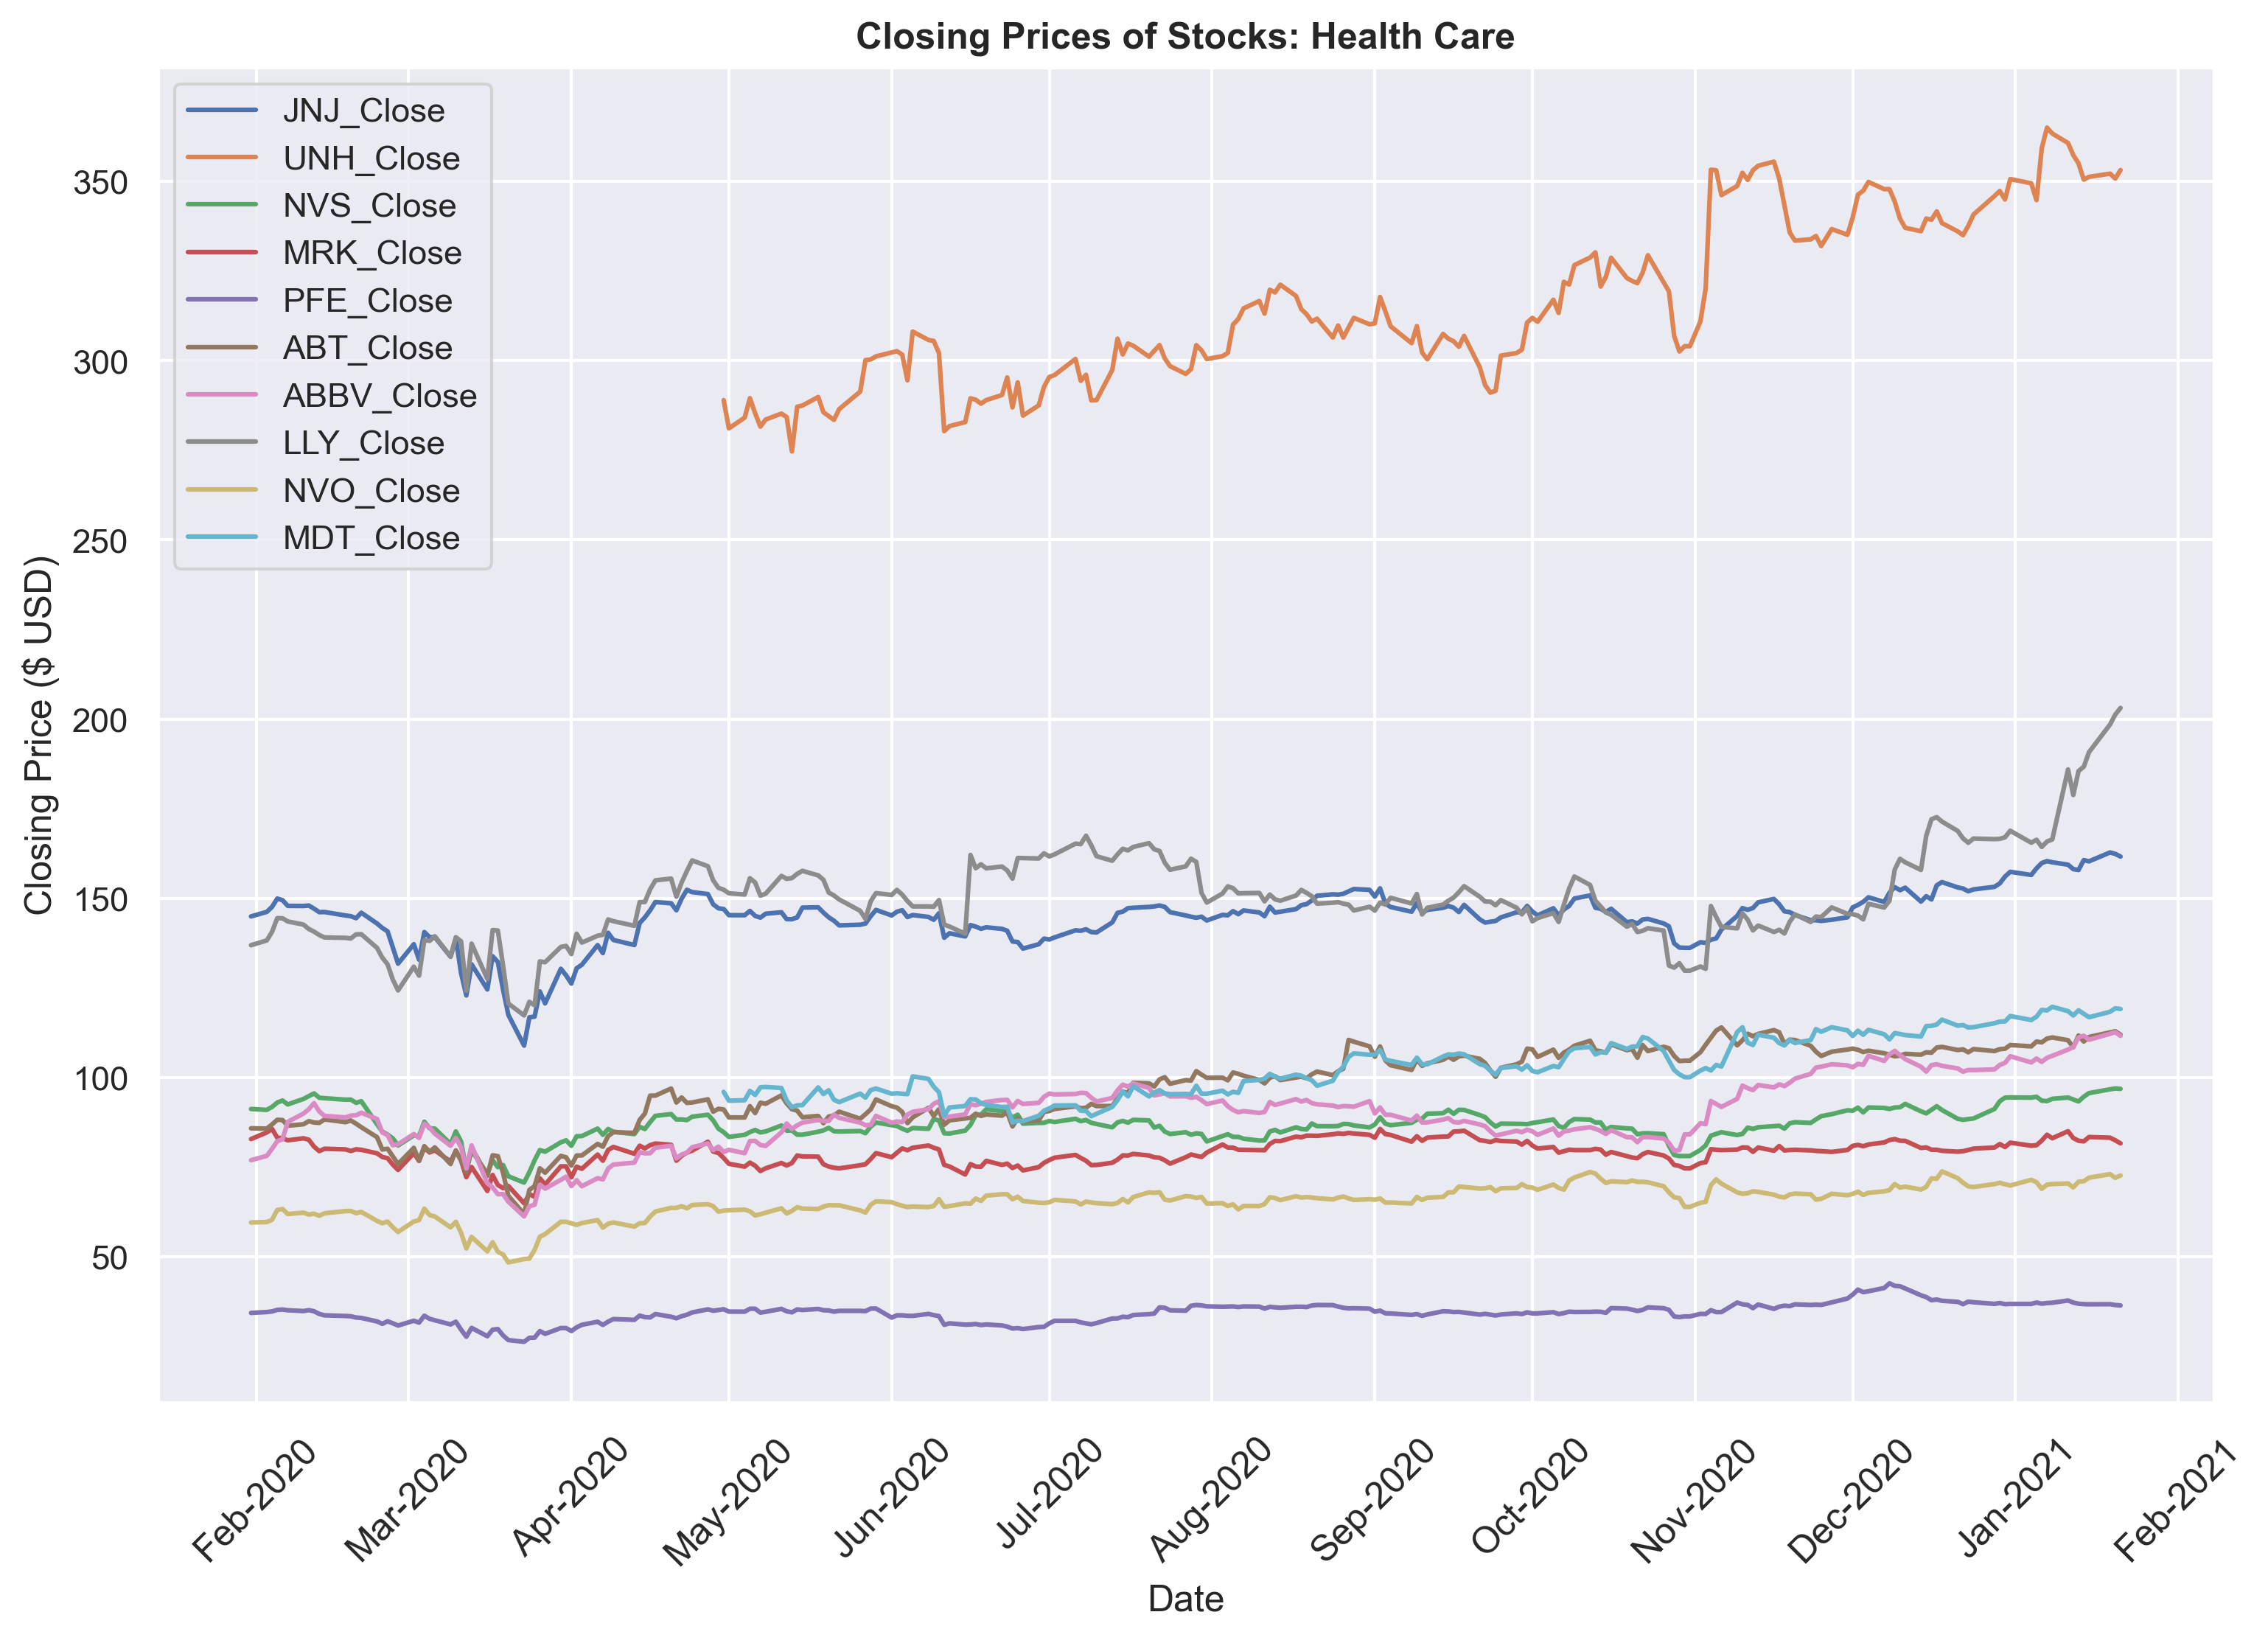

In [30]:
plot_prices(df_tickers, 'Health Care')

['JPM', 'BAC', 'HDB', 'WFC', 'C', 'RY', 'HSBC', 'BLK', 'SCHW', 'TD']


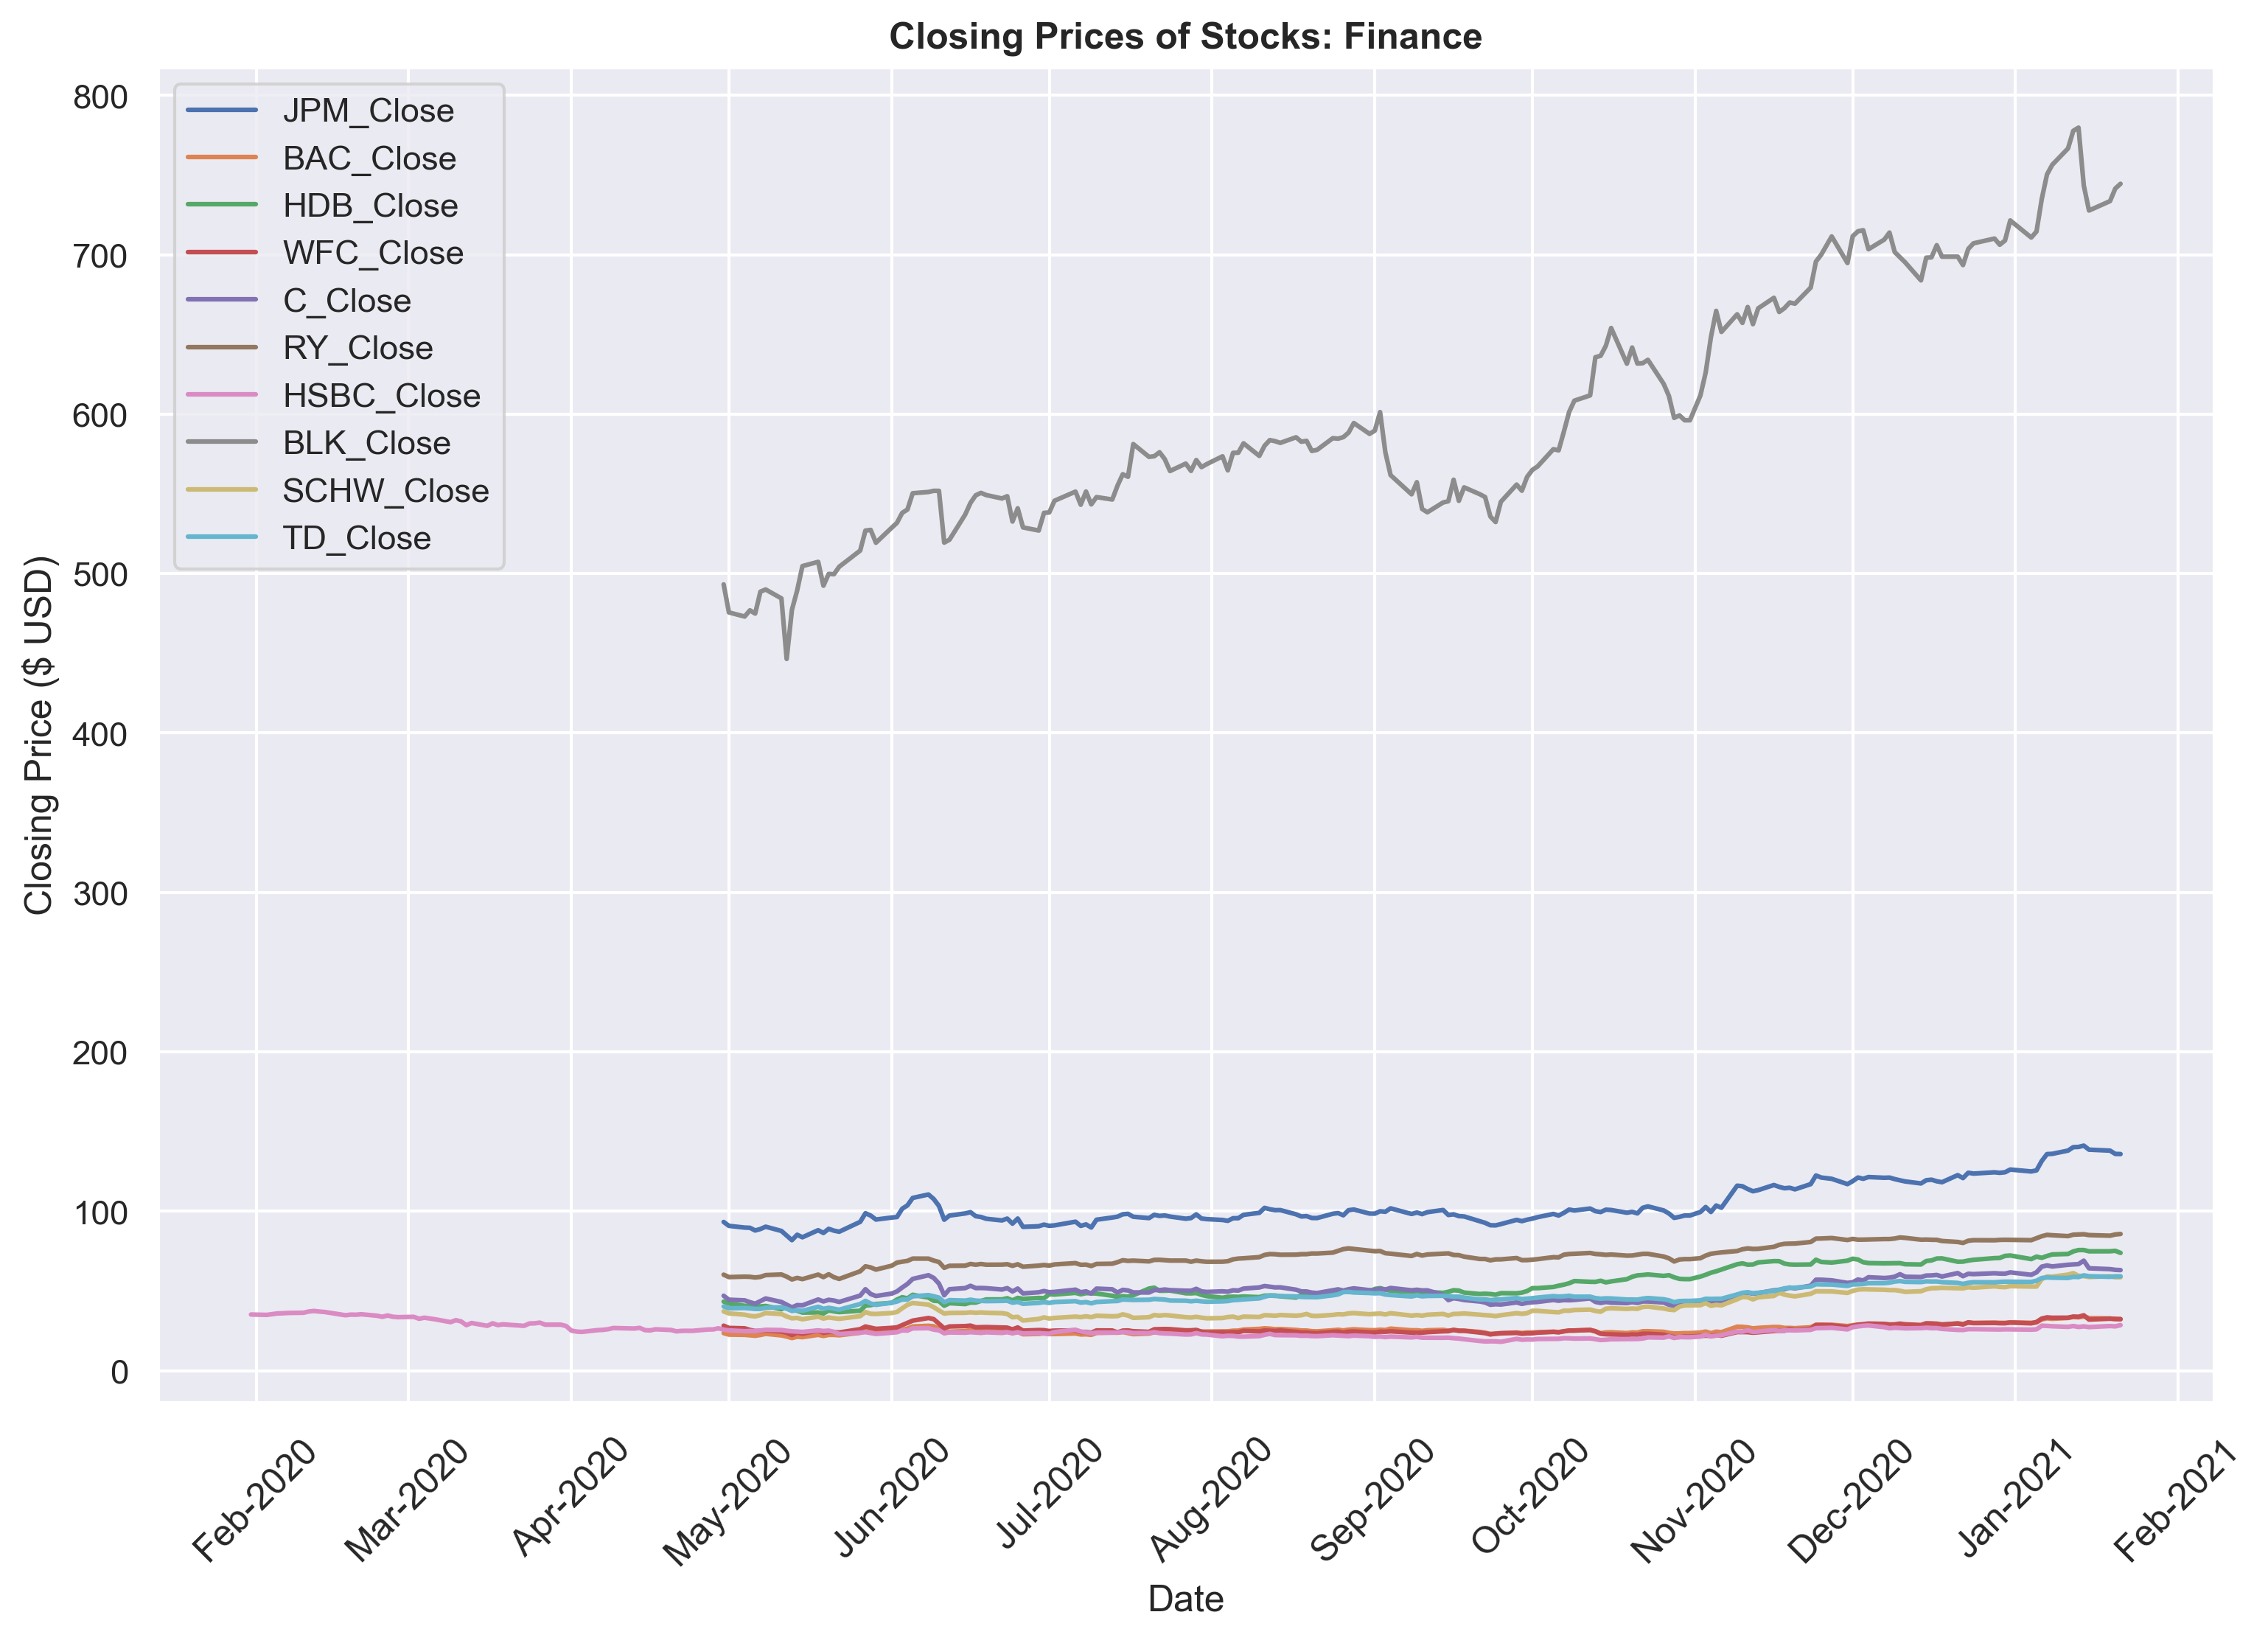

In [31]:
plot_prices(df_tickers, 'Finance')

In [32]:
plot_prices(df_tickers, 'Consumer Services')

['WMT', 'DIS', 'HD', 'NFLX', 'CMCSA', 'AMZN', 'COST', 'MCD', 'JD', 'CHTR']


ChunkedEncodingError: ('Connection broken: IncompleteRead(0 bytes read)', IncompleteRead(0 bytes read))

In [ ]:
plot_prices(df_tickers, 'Technology')

In [ ]:
plot_prices(df_tickers, 'Capital Goods')

In [ ]:
plot_prices(df_tickers, 'Basic Industries')

In [ ]:
plot_prices(df_tickers, 'Energy')

In [ ]:
plot_prices(df_tickers, 'Consumer Durables')

In [ ]:
plot_prices(df_tickers, 'Consumer Non-Durables')

In [ ]:
plot_prices(df_tickers, 'Public Utilities')

In [ ]:
plot_prices(df_tickers, 'Transportation')

In [ ]:
plot_prices(df_tickers, 'Miscellaneous')

### 3.2. Stock Clustering Before vs. During COVID-19

In [ ]:
# create clustering function, percent change columns of closing price
def plot_cluster_sector(df_tickers, sector):
    
    # get top 10 tickers for sector, process, and filter columns for closing prices
    tickers = top_tickers(df_tickers, sector)
    df = stock_preprocess(tickers)
    cols = df.columns[df.columns.str.contains(pat = 'Close')] 
    df = df[cols]
    df = df.rename(columns=lambda x: x.replace('_Close', ''))
    
    # fill in sentiment results
    df = df.replace(0,)
    df = df.interpolate('linear')
    df = df.dropna()
    
    # transpose news orgs and dates
    df = df.transpose()
 
    # create labels
    labels = list(df.index)

    # create linkages
    Z = linkage(df, 'ward')

    # make the dendrogram
    sns.set()
    fig, ax = plt.subplots(figsize = (12,8), dpi=300)  
    plt.title('Hierarchical Clustering Dendrogram', fontweight = 'bold')
    plt.xlabel('stocks')
    plt.ylabel('distance (Ward)')
    dendrogram(Z, labels=df.index, leaf_rotation=90)
    plt.show() 
    
_ = plot_cluster_sector(df_tickers, sector = ['Technology'])

In [ ]:
# create clustering function, percent change columns of closing price
def plot_cluster_stocks(tickers):
    
    # get top 10 tickers for sector, process, and filter columns for closing prices
#     tickers = top_tickers(df_tickers, sector)
    df = stock_preprocess(tickers)
    cols = df.columns[df.columns.str.contains(pat = 'Close')] 
    df = df[cols]
    df = df.rename(columns=lambda x: x.replace('_Close', ''))
    
    # fill in sentiment results
    df = df.replace(0,)
    df = df.interpolate('linear')
    df = df.dropna()
    
    # transpose news orgs and dates
    df = df.transpose()
 
    # create labels
    labels = list(df.index)

    # create linkages
    Z = linkage(df, 'ward')

    # make the dendrogram
    sns.set()
    fig, ax = plt.subplots(figsize = (12,8), dpi=300)  
    plt.title('Hierarchical Clustering Dendrogram', fontweight = 'bold')
    plt.xlabel('stocks')
    plt.ylabel('distance (Ward)')
    dendrogram(Z, labels=df.index, leaf_rotation=90)
    plt.show() 
    
_ = plot_cluster_sector(tickers = ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOGL', 'MSFT'])

### 3.3. Financial News Sentiment By Source 

In [ ]:
def plot_sentiment(df):
    
    # get top 10 tickers for sector, process, and filter columns for closing prices
    cols = df.columns[df.columns.str.contains(pat = '_sentiment')] 
    df = df[cols]
    df = df.rename(columns=lambda x: x.replace('_sentiment', ''))
    
    # fill in sentiment results
    df = df.replace(0,)
    df = df.interpolate('linear')
    df = df.dropna()
    df = df.resample('M').mean()
    
    # set seaborn style, plot options and plot closing prices
    sns.set()
    fig, ax = plt.subplots(figsize = (12,8), dpi=300)
    sns.lineplot(data=df, dashes=False)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    plt.xticks(rotation=45, fontsize=12) 
    ax.set_title('Financial News Sentiment', fontweight ='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sentiment (-1 = Neg., +1 = Pos.)')
    plt.show()
    
    # print highest sentiment to lowest sentiment news sources
    print('Average News Sentiment by Source: \n\n{}'.format(df.mean().sort_values(ascending=False)))

In [ ]:
plot_sentiment(df_news)

### 3.4. Stock Correlation to Financial News Sentiment

In [ ]:
# get top 10 tickers of all sectors
all_tickers = list(df_tickers['Sector'].unique())
top_tickers_all = top_tickers(df_tickers, sector = all_tickers)
print(top_tickers_all)

In [ ]:
# preprocess ticker list to get values
def stock_preprocess_prices(tickers):
    
    # create empty dataframe
    df_api = pd.DataFrame()
    
    # loop over each stock ticker
    for tick in tickers:
            
        # input various stock tickers 
        ticker = yf.Ticker(tick)
        
        # get historical market data
        stock_hist = ticker.history(period="1y", interval='1D')
    
        # filter columns for closing price
        stock_hist = stock_hist[['Close']]
        
        # fill in nan values and drop remaining nan values
        stock_hist = stock_hist.interpolate(method='linear', limit_direction = 'forward', axis=0)
#         stock_hist = stock_hist.fillna(method = 'ffill')
#         stock_hist = stock_hist.dropna()
#         stock_hist = stock_hist.drop_duplicates()
        
        # rename columns with ticker name
        stock_hist = stock_hist.rename(columns=lambda x: tick.upper() + '_c')

        # concat to empty dataframe
        df_api = pd.concat([df_api, stock_hist], axis=1)
        
    return df_api
        
df_all = stock_preprocess_prices(tickers = top_tickers_all)  
df_all.tail()

In [ ]:
# merge news dataframe overall sentiment with df_all dataframe
df_all = pd.merge(df_all, df_news[['overall_sentiment']], left_index=True, right_index=True, how='outer')

# filter for weekdays when stock price changes
df_all['day_of_week'] = df_all.index.dayofweek
df_all = df_all[(df_all['day_of_week'] >= 0) & (df_all['day_of_week'] <= 4)]

# plot correlation heatmap across all stocks to view correlation
plt.figure(dpi=300)
sns.heatmap(df_all.corr()) 

# print correlation values to determine stocks most correlated with news sentiment
correlation_mat = df_all.corr()
corr_pairs = correlation_mat.unstack()
print(corr_pairs['overall_sentiment'].sort_values(kind="quicksort", ascending=False).iloc[:10])

In [ ]:
def top_tickers(df, sector):
    
    ticker_list = []
    
    for sec in sector:
                
        # filter by sector and sort by market cap
        df_tick = df[df['Sector'] == sec].sort_values(by='MarketCap', ascending=False)
        df_tick = list(df_tick.iloc[:10]['Symbol'])   
        
        for tick in df_tick:
            
            ticker_list.append(tick)
                         
    return ticker_list  

# print sample data
top_tickers(df_tickers, sector = ['Technology', 'Consumer Durables'])


In [ ]:
# print number of companies per sector
print(list(df_tickers['Sector'].unique()))

In [ ]:
# preprocess ticker list to get values
def stock_preprocess_avg(sectors):

    # create empty dataframe
    df_sector = pd.DataFrame()
    
    # loop over sectors
    for sec in sectors:
        
        # get list of tickers for each sector
        tickers = top_tickers(df_tickers, sector = [sec])
        
        # create empty dataframe
        df_stocks = pd.DataFrame()
        
        # loop over each stock ticker
        for tick in tickers:

            # input various stock tickers 
            ticker = yf.Ticker(tick)

            # get historical market data
            stock_hist = ticker.history(period="1y", interval='1D')

            # filter columns for closing price
            stock_hist = stock_hist[['Close']]

            # fill in nan values and drop remaining nan values
            stock_hist = stock_hist.interpolate(method='linear', limit_direction = 'forward', axis=0)
    #         stock_hist = stock_hist.fillna(method = 'ffill')
#             stock_hist = stock_hist.dropna()
#             stock_hist = stock_hist.drop_duplicates()

            # rename columns with ticker name
            stock_hist = stock_hist.rename(columns=lambda x: tick.upper() + '_' + x)

            # concat to empty dataframe
            df_stocks = pd.concat([df_stocks, stock_hist], axis=1)
            
        # create average price columns
        df_avg = pd.DataFrame(df_stocks.mean(axis=1))
        df_avg = df_avg.rename(columns=lambda x: str(sec))
        
        # concat to empty dataframe
        df_sector = pd.concat([df_sector, df_avg], axis=1)

    # remove duplicated indexes (dates)
    df_sector = df_sector.drop(columns = ['nan'])
    df_sector = df_sector[~df_sector.index.duplicated()]

    return df_sector
        
df_sector = stock_preprocess_avg(sectors = list(df_tickers['Sector'].unique()))  
df_sector.tail()

In [ ]:
# preprocess ticker list to get values
def stock_preprocess_avg_ind(industry):

    # create empty dataframe
    df_industry = pd.DataFrame()
    
    # loop over sectors
    for ind in industry:
        
        # get list of tickers for each sector
        tickers = top_tickers_industry(df_tickers, industry = [ind])
        
        # create empty dataframe
        df_stocks = pd.DataFrame()
        
        # loop over each stock ticker
        for tick in tickers:

            # input various stock tickers 
            ticker = yf.Ticker(tick)

            # get historical market data
            stock_hist = ticker.history(period="1y", interval='1D')

            # filter columns for closing price
            stock_hist = stock_hist[['Close']]

            # fill in nan values and drop remaining nan values
            stock_hist = stock_hist.interpolate(method='linear', limit_direction = 'forward', axis=0)
    #         stock_hist = stock_hist.fillna(method = 'ffill')
#             stock_hist = stock_hist.dropna()
#             stock_hist = stock_hist.drop_duplicates()

            # rename columns with ticker name
            stock_hist = stock_hist.rename(columns=lambda x: tick.upper() + '_' + x)

            # concat to empty dataframe
            df_stocks = pd.concat([df_stocks, stock_hist], axis=1)
            
        # create average price columns
        df_avg = pd.DataFrame(df_stocks.mean(axis=1))
        df_avg = df_avg.rename(columns=lambda x: str(ind))
        
        # concat to empty dataframe
        df_industry = pd.concat([df_industry, df_avg], axis=1)

    # remove duplicated indexes (dates)
#     df_industry = df_industry.drop(columns = ['nan'])
    df_industry = df_industry[~df_industry.index.duplicated()]

    return df_industry
        
df_industry = stock_preprocess_avg_ind(industry = list(df_tickers['industry'].unique()))  
df_industry.tail()

In [ ]:
def industry_returns(df):
    
    # drop first row of nan values
    df = df.iloc[1:,]
    
    # create empty list
    returns_ = []
    
    # loop over columns
    for x in df.columns:
        
        # create initial val based on pandemic start date, final val based on current date, and calc percent chg
        init_val = df[x][0]
        # init_val = df.loc['2020-03-02'][x]
        final_val = df[x][-1]
        pct_chg = ((final_val - init_val)/(init_val))*100
        
        # append dict to list
        returns_.append(dict({'industry': x, 'pandemic_change%':pct_chg})) 

    # create pandas dataframe based on list 
    df_returns = pd.DataFrame(returns_, columns=['industry', 'pandemic_change%'])
    df_returns = df_returns.sort_values(by='pandemic_change%', ascending=False)
    df_returns = df_returns.reset_index(drop=True)
    
    return df_returns
        
df_industry_returns = industry_returns(df_industry)
print('Best Returns: \n\n{}'.format(df_industry_returns.iloc[:10]))
print('\nWorst Returns: \n\n{}'.format(df_industry_returns.sort_values(by = 'pandemic_change%', ascending=True).iloc[:10]))

In [ ]:
def sector_returns(df):
    
    # drop first row of nan values
    df = df.iloc[1:,]
    
    # create empty list
    returns_ = []
    
    # loop over columns
    for x in df.columns:
        
        # create initial val based on pandemic start date, final val based on current date, and calc percent chg
        init_val = df[x][0]
        # init_val = df.loc['2020-03-02'][x]
        final_val = df[x][-1]
        pct_chg = ((final_val - init_val)/(init_val))*100
        
        # append dict to list
        returns_.append(dict({'sector': x, 'pandemic_change%':pct_chg})) 

    # create pandas dataframe based on list 
    df_returns = pd.DataFrame(returns_, columns=['sector', 'pandemic_change%'])
    df_returns = df_returns.sort_values(by='pandemic_change%', ascending=False)
    df_returns = df_returns.reset_index(drop=True)
    
    return df_returns
        
df_sector_returns = sector_returns(df_sector)
df_sector_returns

In [ ]:
def stock_returns(df):
    
    # drop first row of nan values
    df = df.iloc[1:,]
    
    # create empty list
    returns_ = []
    
    # loop over columns
    for x in df.columns:
        
        # create initial val based on pandemic start date, final val based on current date, and calc percent chg
        init_val = df[x][0]
        # init_val = df.loc['2020-03-02'][x]
        final_val = df[x][-1]
        pct_chg = ((final_val - init_val)/(init_val))*100
        
        # append dict to list
        returns_.append(dict({'ticker': x, 'pandemic_change%':pct_chg})) 

    # create pandas dataframe based on list 
    df_returns = pd.DataFrame(returns_, columns=['ticker', 'pandemic_change%'])
    df_returns = df_returns.sort_values(by='pandemic_change%', ascending=False)
    df_returns = df_returns.reset_index(drop=True)
    
    return df_returns
        
df_stock_returns = stock_returns(df_all)
print('Best Returns: \n\n{}'.format(df_stock_returns.iloc[:10]))
print('\nWorst Returns: \n\n{}'.format(df_stock_returns.sort_values(by = 'pandemic_change%', ascending=True).iloc[:10]))

In [ ]:
def plot_sector_prices(df):
    
    # set seaborn style, plot options and plot closing prices
    sns.set()
    fig, ax = plt.subplots(figsize = (12,8), dpi=300)
    sns.lineplot(data=df, dashes=False)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    plt.xticks(rotation=45, fontsize=12) 
    ax.set_title('Avg Sector Prices of Stocks', fontweight ='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Closing Price ($ USD)')
    plt.show()
    
plot_sector_prices(df_sector)      

In [ ]:
# merge news dataframe overall sentiment with df_all dataframe
df_all_2 = pd.merge(df_sector, df_news[['overall_sentiment']], left_index=True, right_index=True, how='outer')

# filter for weekdays when stock price changes
df_all_2['day_of_week'] = df_all_2.index.dayofweek
df_all_2 = df_all_2[(df_all_2['day_of_week'] >= 0) & (df_all_2['day_of_week'] <= 4)]

# plot correlation heatmap across all stocks to view correlation
plt.figure(dpi=300)
sns.heatmap(df_all_2.corr()) 

# print correlation values to determine stocks most correlated with news sentiment
correlation_mat = df_all_2.corr()
corr_pairs = correlation_mat.unstack()
# print(corr_pairs['overall_sentiment'].sort_values(kind="quicksort", ascending=False).iloc[:10])

## 4. Data Prediction

In [45]:
# print sample data call function with ticker_input
df_test = stock_preprocess(['AMZN', 'AAPL'])
df_test.tail()

,AMZN_Close,AMZN_Volume,AMZN_Revenue,AMZN_Earnings,AAPL_Close,AAPL_Volume,AAPL_Revenue,AAPL_Earnings
Date,,,,,,,,
2021-01-14,3127.469971,3070900.0,9.614500e+10,6.331000e+09,128.910004,90221800.0,6.469800e+10,1.267300e+10
2021-01-15,3104.250000,4244000.0,9.614500e+10,6.331000e+09,127.139999,111598500.0,6.469800e+10,1.267300e+10
2021-01-19,3120.760010,3305100.0,9.614500e+10,6.331000e+09,127.830002,90757300.0,6.469800e+10,1.267300e+10
2021-01-20,3263.379883,5299400.0,9.614500e+10,6.331000e+09,132.029999,103900700.0,6.469800e+10,1.267300e+10
2021-01-21,3313.004883,1096704.0,9.614500e+10,6.331000e+09,134.830002,19903301.0,6.469800e+10,1.267300e+10


                   AMZN_5current_pct  AMZN_5future_pct
AMZN_5current_pct           1.000000         -0.060869
AMZN_5future_pct           -0.060869          1.000000


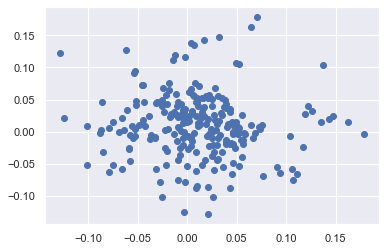

In [47]:
df_test['AMZN_5future_close'] = df_test['AMZN_Close'].shift(-5)
df_test['AMZN_5current_pct'] = df_test['AMZN_Close'].pct_change(5)
df_test['AMZN_5future_pct'] = df_test['AMZN_5future_close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = df_test[['AMZN_5current_pct', 'AMZN_5future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(df_test['AMZN_5current_pct'], df_test['AMZN_5future_pct'])
plt.show()



### 4.1. Feature Engineering

In [ ]:
# create rolling window features
def rolling_(df):
 
    # create empty df  
    df_rolling = pd.DataFrame()
    
    # define the features you'll calculate for each window
    features_stats = [np.min, np.max, np.mean, np.std]
    
    # define rolling percentiles
    percentiles = [0.1, 0.2, 0.9]
    
    # define a rolling window with Pandas, excluding the right-most datapoint of the window
    rolling_ = df.rolling(20, min_periods=5, closed='right')

    # Calculate stat features for rolling window object and concat to empty df
    rolling_stats = rolling_.aggregate(features_stats).dropna()
    rolling_stats.columns = rolling_stats.columns.map('_'.join)
    df_rolling = pd.concat([df_rolling, rolling_stats], axis=1, sort=False)

    # calculate percentiles for rolling window
    for perc in percentiles:
        
        rolling_perc = rolling_.quantile(perc, interpolation='linear').dropna()
        perc_num = perc*100
        rolling_perc = rolling_perc.rename(columns=lambda x: "{}_{}perc".format(x, perc_num))
        df_rolling = pd.concat([df_rolling, rolling_perc], axis=1, sort=False)
          
    return df_rolling
        
# df_rolling = rolling_(df_fundamentals) 
# df_rolling.head()

In [ ]:
# create day shifted features
def shift_(df):
    
    # create empty dataframe
    df_shift = pd.DataFrame()

    # create day shifts
    shifts = [1, 3, 5, 10, 30, 60, 90, 180]
    
    # loop over days shifts, and shift each column, rename columns, and concat to dataframe 
    for day_shift in shifts:
        
        df_shifted = df.shift(day_shift, axis = 0)
        df_shifted = df_shifted.rename(columns=lambda x: "{}_{}daylag".format(x, day_shift)) 
        df_shift = pd.concat([df_shift, df_shifted], axis=1, sort=False)

    return df_shift

# df_shifted = shift_(df_fundamentals)
# df_shifted.head() 

In [ ]:
# create day, week, month features
def day_(df):
    
    # create day, week, month column
    df.index = pd.to_datetime(df.index)
    df['day_of_week'] = df.index.weekday
    df['week_of_year'] = df.index.week
    df['month_of_year'] = df.index.month
    df_day = df[['day_of_week', 'week_of_year', 'month_of_year']] 
    
    return df_day

# df_day = day_(df_fundamentals)
# df_day.head()

In [ ]:
# concat fundamentals with features (rolling, shifted, and day/week/months)
def overall_stock_preprocess(tickers):
    
    # call first stock preprocess function with list of tickers, call other functions, and concatenate results
    df_stock_preprocess = stock_preprocess(tickers)
    df_rolling = rolling_(df_stock_preprocess)
    df_shift = shift_(df_stock_preprocess)
    df_day = day_(df_stock_preprocess)
    df_overall = pd.concat([df_stock_preprocess, df_rolling, df_shift, df_day], axis=1, sort=False)
    df_overall.head()
    
    return df_overall

overall_stock_preprocess(['LUV', 'SHAK', 'BBY'])

### 4.2. (Model 1)

### 4.3. Model (2)

### 4.4. Model (3)

### 4.5. Model (4)

## 5. Conclusion